# MWPM decoder (with `pymatching`)

In [1]:
import pathlib
from datetime import datetime
from typing import Optional

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

import pymatching
import stim
import sinter

from qrennd import get_model, Config, Layout
from qrennd.layouts.plotter import plot

In [2]:
def get_syndromes(anc_meas: xr.DataArray) -> xr.DataArray:
    syndromes = anc_meas ^ anc_meas.shift(qec_round=1, fill_value=0)
    syndromes.name = "syndromes"
    return syndromes


def get_defects(
    syndromes: xr.DataArray, frame: Optional[xr.DataArray] = None
) -> xr.DataArray:
    shifted_syn = syndromes.shift(qec_round=1, fill_value=0)

    if frame is not None:
        shifted_syn[dict(qec_round=0)] = frame

    defects = syndromes ^ shifted_syn
    defects.name = "defects"
    return defects


def get_final_defects(
    syndromes: xr.DataArray,
    proj_syndrome: xr.DataArray,
) -> xr.DataArray:
    last_syndrome = syndromes.isel(qec_round=-1)
    proj_anc = proj_syndrome.anc_qubit

    final_defects = last_syndrome.sel(anc_qubit=proj_anc) ^ proj_syndrome
    final_defects.name = "final_defects"
    return final_defects


def preprocess_data(dataset, proj_mat, first_anc_detector=["Z1", "Z2", "Z3", "Z4"]):
    anc_meas = dataset.anc_meas.stack(state_shot = ("log_state", "shot"))
    anc_meas = anc_meas.transpose("state_shot", "qec_round", "anc_qubit")
    
    data_meas = dataset.data_meas.stack(state_shot = ("log_state", "shot"))
    data_meas = data_meas.transpose("state_shot", "data_qubit")

    syndromes = get_syndromes(anc_meas)
    defects = get_defects(syndromes)
    
    first_defects = defects.sel(qec_round=1, anc_qubit=first_anc_detector).values
    
    defects = defects.sel(qec_round=defects.qec_round[1:])
    defects = defects.stack(n=["qec_round", "anc_qubit"]).values
    
    proj_syndrome = (data_meas @ proj_mat) % 2
    final_defects = get_final_defects(syndromes, proj_syndrome)

    defects = np.append(first_defects, defects, axis=1)
    defects = np.append(defects, final_defects, axis=1)

    log_meas = dataset.data_meas.sum(dim="data_qubit") % 2
    log_inits = dataset.init_state.sum(dim="data_qubit") % 2
    log_errors = log_meas ^ log_inits
    log_errors = log_errors.stack(state_shot=("log_state", "shot"))

    return defects, log_errors.data

# Load the dataset (for testing)

In [3]:
NOTEBOOK_DIR = pathlib.Path.cwd() # define the path where the notebook is placed.

LAYOUT_DIR = NOTEBOOK_DIR / "layouts"
if not LAYOUT_DIR.exists():
    raise ValueError("Layout directory does not exist.")

CONFIG_DIR = NOTEBOOK_DIR / "configs"
if not CONFIG_DIR.exists():
    raise ValueError("Config directory does not exist.")

# The train/dev/test data and stim_circuit directories are located in the local data directory
DATA_DIR = NOTEBOOK_DIR / "data"
if not DATA_DIR.exists():
    raise ValueError("Data directory does not exist.")

cur_datetime = datetime.now()
datetime_str = cur_datetime.strftime("%Y%m%d-%H%M%S")

LOG_DIR = NOTEBOOK_DIR / f"logs/{datetime_str}"
LOG_DIR.mkdir(parents=True, exist_ok=True)

CHECKPOINT_DIR = NOTEBOOK_DIR / "tmp/checkpoint"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

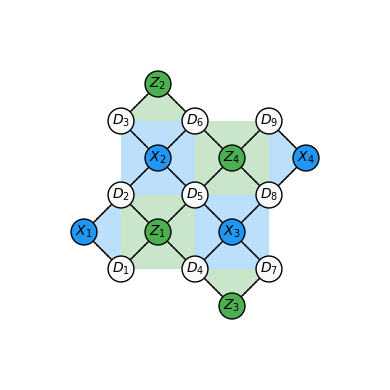

In [4]:
LAYOUT_FILE = "d3_rotated_layout.yaml"
layout = Layout.from_yaml(LAYOUT_DIR / LAYOUT_FILE)

fig, ax = plt.subplots(figsize=(4, 4))
plot(layout, label_qubits=True, draw_patches=True, axis=ax)
plt.tight_layout()
plt.show()

In [5]:
CONFIG_FILE = "base_config.yaml"
config = Config.from_yaml(CONFIG_DIR / CONFIG_FILE)

In [6]:
proj_mat = layout.projection_matrix(stab_type="z_type")

C:\Users\Lurdes\Arxius\Marc\TU_DELFT\courses\master_thesis_project\repositories\qrennd\qrennd\layouts\layout.py:145: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(self.graph)


In [7]:
test_dataset = xr.load_dataset(
    DATA_DIR / "test/d3_surf_circ_noise_shots_10000_rounds_60.nc"
)
defects, log_errors = preprocess_data(test_dataset, proj_mat)

In [8]:
defects.shape, log_errors.shape

((20000, 480), (20000,))

In [9]:
defects[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Prepare decoder

In [10]:
DETECTOR_ERROR_MODEL = DATA_DIR / "stim_error_model/detector_error_model"
if not DETECTOR_ERROR_MODEL.exists():
    raise ValueError(f"stim model does not exist in file: {DETECTOR_ERROR_MODEL}")

detector_error_model = stim.DetectorErrorModel.from_file(DETECTOR_ERROR_MODEL)

MWPM = pymatching.Matching.from_detector_error_model(detector_error_model)

# Evaluation of the decoder

In [11]:
prediction = np.array([MWPM.decode(i) for i in defects]).flatten()

In [12]:
np.sum(log_errors == prediction) / len(prediction)

0.8675